# Slay the Spire Run Outcome Classification

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
import json
from pathlib import Path
from glob import glob
import warnings

In [3]:
plt.style.use("seaborn-v0_8")

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc

## Table of Contents

- [All Links in Document](#links)
- [Introduction](#introduction)
- [Data Merging](#merge)
- [Data Preparation](#prep)
- [Data Understanding](#understand)
- [Modelling](#model)
- [The Heart](#heart)
- [Conclusion](#conclusion)

## All Links in Document <a name="links" />

- https://slay-the-spire.fandom.com/wiki/Mind_Bloom

## Introduction <a name="introduction" />

## Data Merging <a name="merge" />

In [ ]:
files_raw = glob("data/raw/*.json")

In [ ]:
len(files_raw)

In [ ]:
q1 = files_raw[:400]
q2 = files_raw[400:800]
q3 = files_raw[800:1200]
q4 = files_raw[1200:]

file_quarters_dict = {"q1": q1, "q2": q2, "q3": q3, "q4": q4}

In [ ]:
Path(f"asdf")

In [ ]:
def merge_json(out_name, file_list):
    result = []
    for i, file in enumerate(file_list):
        print(f"Quarter: {out_name} | File: {i+1}/{len(file_list)}", end="\r")
        with open(file, 'r') as f:
            result.extend(json.load(f))

    with open(Path(f'data/combined/merged_{out_name}.json'), 'w') as output_file:
        json.dump(result, output_file, indent="")

In [ ]:
for key, value in file_quarters_dict.items():
    merge_json(key, value)

In [ ]:
files_json = glob("data/combined/*.json")

In [ ]:
files_json

In [ ]:
files_json_dict = {"q1": files_json[0], "q2": files_json[1], "q3": files_json[2], "q4": files_json[3]}
files_json_dict

In [ ]:
def json_to_csv(out_name, json_file_paths):
    with open(f"{json_file_paths}", "r") as f:
        raw = json.loads(f.read())
        df = pd.json_normalize(raw)
        df.to_csv(f"data/combined/csv_{out_name}.csv", index=False)

In [ ]:
for key, value in files_json_dict.items():
    json_to_csv(key, value)

In [ ]:
def merge_csv():
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore')
        files_csv = glob("data/combined/*.csv")
        df = pd.concat(map(pd.read_csv, files_csv), ignore_index=True)
        df.to_csv("data/full/full.csv", index=False)

In [ ]:
merge_csv()

## Data Preparation <a name="prep" />

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore')
    df = pd.read_csv("data/full/full.csv")

In [ ]:
df.columns = df.columns.str.replace("event\.", "", regex=True)

In [ ]:
pd.options.display.max_columns = 60
df.head(3)

In [ ]:
print(df[df["is_trial"] != False].shape[0])
print(df[df["circlet_count"] > 0].shape[0])
print(df[df["is_prod"] != False].shape[0])
print(df[df["is_daily"] != False].shape[0])
print(df[df["chose_seed"] != False].shape[0])
print(df[df["is_beta"] != False].shape[0])
print(df[df["is_endless"] != False].shape[0])

In [ ]:
df = df.drop(columns=['playtime', 'items_purged', 'score', 'play_id', 'local_time',
                      'is_ascension_mode', 'campfire_choices', 'seed_source_timestamp',
                      'circlet_count', 'damage_taken', 'seed_played', 'potions_obtained', 'is_trial', 
                      'path_per_floor', 'items_purchased', 'item_purchase_floors',
                      'current_hp_per_floor', 'gold', 'is_prod', 'is_daily', 
                      'chose_seed', 'win_rate', 'timestamp', 'build_version', 
                      'max_hp_per_floor', 'card_choices', 'player_experience', 
                      'relics_obtained', 'event_choices', 'is_beta', 'boss_relics', 
                      'items_purged_floors', 'is_endless', 'potions_floor_spawned', 
                      'special_seed', 'neow_bonus', 'neow_cost'])

In [ ]:
df.rename({"gold_per_floor": "total_gold_spent", "master_deck": "final_deck_size",
           "potions_floor_usage": "potions_used", "path_taken": "elites_killed"}, axis="columns", inplace=True)

In [ ]:
df.head(3)

In [ ]:
df.isna().sum()

In [ ]:
df = df.loc[df["floor_reached"].isin([0, 1, 2, 3]) == False]

In [ ]:
df = df.loc[df["floor_reached"] <= 55]

In [ ]:
df = df.loc[df["ascension_level"].isin([*range(0, 21)])]

In [ ]:
df = df.loc[df["total_gold_spent"] != "[]"]

In [ ]:
df = df.loc[df["purchased_purges"] <= 8]

In [ ]:
df = df.loc[df["campfire_upgraded"] <= 13]

In [ ]:
df = df.loc[df["killed_by"].isin(["Slaver and Parasite", "Flame Bruiser 2 Orb", 
                                  "Replay:BlueRogue", "Flame Bruiser 1 Orb", 
                                  "Fading Forest", "Replay:Snechameleon"]) == False]

In [ ]:
df.loc[(df["victory"] == True) & (df["killed_by"].isna()), "killed_by"] = "None"

In [ ]:
df["killed_by"].fillna("Misc", inplace=True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df.isna().sum()

In [ ]:
def calculate_gold_spent(gpr):
    gold_per_run = []
    for run in gpr:
        list_of_strings = run.strip("][").split(", ")
        list_of_ints = [eval(i) for i in list_of_strings]

        gold = 0
        for i, value in enumerate(list_of_ints[1:]):
            if value < list_of_ints[i]:
                gold += (list_of_ints[i] - value)

        gold_per_run.append(gold)
        
    return gold_per_run

In [ ]:
total_gold_spent_per_run = calculate_gold_spent(df.loc[:, "total_gold_spent"])

In [ ]:
len(total_gold_spent_per_run), df.shape[0]

In [ ]:
df["total_gold_spent"] = total_gold_spent_per_run

In [ ]:
df["total_gold_spent"].max()

In [ ]:
df["total_gold_spent"].describe()

In [ ]:
df.loc[df["total_gold_spent"] > 2000].shape[0]

In [ ]:
df = df.loc[df["total_gold_spent"] < 2000]

In [ ]:
df.head(3)

In [ ]:
def calculate_deck_size(dspr):
    deck_sizes = []
    for deck in dspr:
        list_of_strings = deck.strip("][").split(", ")
        deck_sizes.append(len(list_of_strings))
        
    return deck_sizes

In [ ]:
deck_size_per_run = calculate_deck_size(df.loc[:, "final_deck_size"])

In [ ]:
len(deck_size_per_run), df.shape[0]

In [ ]:
df["final_deck_size"] = deck_size_per_run

In [ ]:
df["final_deck_size"].max()

In [ ]:
df["final_deck_size"].describe()

In [ ]:
df[df["final_deck_size"] > 55].shape[0]

In [ ]:
df = df.loc[df["final_deck_size"] <= 55]

In [ ]:
df.head(3)

In [ ]:
def calculate_relic_frequency(lists):
    result = {}
    for i, lst in enumerate(lists):
        list_of_strings = lst.strip("][").replace("\"", "").replace("\'", "").split(", ")
        for relic in list_of_strings:
            result.setdefault(relic, set()).add(i)
    
    final = {}
    for i, count in result.items():
        final[i] = {"Frequency": len(count), "Occurs": list(count)}
        
    return final

In [ ]:
total_relic_frequency = calculate_relic_frequency(df.loc[:, "relics"])

In [ ]:
len(total_relic_frequency)

In [ ]:
def calculate_relic_count(rcpr):
    relic_counts = []
    for relics in rcpr:
        list_of_strings = relics.strip("][").split(", ")
        relic_counts.append(len(list_of_strings))
        
    return relic_counts

In [ ]:
relic_count_per_run = calculate_relic_count(df.loc[:, "relics"])

In [ ]:
len(relic_count_per_run), df.shape[0]

In [ ]:
df["relics"] = relic_count_per_run

In [ ]:
df["relics"].max()

In [ ]:
df["relics"].describe()

In [ ]:
df[df["relics"] > 30].shape[0]

In [ ]:
df = df.loc[df["relics"] <= 30]

In [ ]:
df.head(3)

In [ ]:
def calculate_potions_used(pupr):
    potion_counts = []
    for potions in pupr:
        list_of_strings = potions.strip("][").split(", ")
        try:
            list_of_ints = [eval(i) for i in list_of_strings]
            potion_counts.append(len(list_of_ints))
        except:
            potion_counts.append(0)
        
    return potion_counts

In [ ]:
potions_used_per_run = calculate_potions_used(df.loc[:, "potions_used"])

In [ ]:
len(potions_used_per_run), df.shape[0]

In [ ]:
df["potions_used"] = potions_used_per_run

In [ ]:
df["potions_used"].max()

In [ ]:
df["potions_used"].describe()

In [ ]:
def calculate_elite_fights(efpr):
    elite_counts = []
    for elite in efpr:
        elite_counts.append(elite.count("E"))
        
    return elite_counts

In [ ]:
elite_fights_per_run = calculate_elite_fights(df.loc[:, "elites_killed"])

In [ ]:
len(elite_fights_per_run), df.shape[0]

In [ ]:
df["elites_killed"] = elite_fights_per_run

In [ ]:
df["elites_killed"].max()

In [ ]:
df["elites_killed"].describe()

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df.to_csv("data/full_prepared.csv", index=False)

# Data Understanding <a name="understand" />

Before exploring any data, it's first important to explain the <span style="color:#D0221a;">Ascension</span> mechanic within Slay the Spire. After successfully besting the final boss of a run, it's possible to toggle <span style="color:#D0221a;">Ascension</span>, which provides additional challenge during subsequent runs. Each time a level is beaten, the next <span style="color:#D0221a;">Ascension</span> level is unlocked. There are twenty difficulty levels in total with each level adding additional challenge in different ways. The <span style="color:#D0221a;">Ascension</span> modifiers, in order, are:

- <span style="color:#D0221a;">Ascension 1</span>: Elites spawn 60% more often
- <span style="color:#D0221a;">Ascension 2</span>: Normal enemies deal more damage with their attacks
- <span style="color:#D0221a;">Ascension 3</span>: Elites deal more damage with their attacks
- <span style="color:#D0221a;">Ascension 4</span>: Bosses deal more damage with their attacks
- <span style="color:#D0221a;">Ascension 5</span>: Heal for 75% of your HP after boss battles instead of 100%
- <span style="color:#D0221a;">Ascension 6</span>: Lose 10% of your health at the start of each run
- <span style="color:#D0221a;">Ascension 7</span>: Normal enemies have more HP and some gain higher block
- <span style="color:#D0221a;">Ascension 8</span>: Elites have more HP
- <span style="color:#D0221a;">Ascension 9</span>: Bosses have more HP and some gain higher block
- <span style="color:#D0221a;">Ascension 10</span>: Obtain 1 Ascender's Bane at the start of each run
- <span style="color:#D0221a;">Ascension 11</span>: Start each run with 1 less potion slot
- <span style="color:#D0221a;">Ascension 12</span>: Upgraded cards are 50% less likely to appear in act 2 and act 3
- <span style="color:#D0221a;">Ascension 13</span>: Bosses drop 25% less gold
- <span style="color:#D0221a;">Ascension 14</span>: Lower your maximum HP (-5 for Ironclad, 4 for the other classes)
- <span style="color:#D0221a;">Ascension 15</span>: Events have less positive outcomes and more severe consequences
- <span style="color:#D0221a;">Ascension 16</span>: Everything in shops costs 10% more
- <span style="color:#D0221a;">Ascension 17</span>: Normal enemies have more challenging movesets and abilities
- <span style="color:#D0221a;">Ascension 18</span>: Elites have more challenging movesets and abilities
- <span style="color:#D0221a;">Ascension 19</span>: Bosses have more challenging movesets and abilities
- <span style="color:#D0221a;">Ascension 20</span>: You fight two bosses in a row at the end of act 3

As the modifiers stack up, nearly every aspect of the game becomes more difficult and nearly every avenue of player strength is crippled in some way. There is a vast difference in difficulty between the base game and <span style="color:#D0221a;">Ascension 20</span>, and for that reason, <span style="color:#D0221a;">Ascension 20</span> will receive additional inspection at all times.

In [ ]:
df = pd.read_csv("data/full_prepared.csv")
df.head()

In [ ]:
all_runs = df["ascension_level"].value_counts().sort_index()

plt.figure(figsize=(10,4))
plt.bar(all_runs.index, all_runs.values, color=["#5074b4" for i in range(len(all_runs)-1)] + ["#D0221a"])
plt.title("Run Distribution per Ascension Level")
plt.xlabel("Ascension Level")
plt.ylabel("# of Runs")
plt.xticks(np.arange(len(all_runs)))
plt.xticks(rotation=0)
plt.show()

This distribution of runs is interesting as the most runs happen in the base game and at <span style="color:#D0221a;">Ascension 20</span>. It's natural that the base game has the most runs as people slowly familiarize themselves with the game. In addition, some players may not enjoy the additional <span style="color:#D0221a;">Ascension</span> difficulty. For the more hardcore players that welcome the highest difficulty, there is little incentive to play the other <span style="color:#D0221a;">Ascension</span> levels.

In [ ]:
runs_a0 = df.loc[df["ascension_level"] == 0, "character_chosen"].value_counts()
runs_a20 = df.loc[df["ascension_level"] == 20, "character_chosen"].value_counts()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.suptitle("Run Distribution per Character for Base Game and Ascension 20")
ax1.bar(runs_a0.index, runs_a0.values)
ax1.set_xlabel("Class")
ax1.set_ylabel("# of Runs")

ax2.bar(runs_a20.index, runs_a20.values, color="#D0221a")
ax2.set_xlabel("Class")
ax2.set_ylabel("# of Runs")
plt.show()

This distribution shows which characters are the most and least popular in Slay the Spire. There are several factors to consider here. The Ironclad is the only character initially available. Each other character, in order, is unlocked for play by completing a run with the previous character. Some people may not enjoy this type of game, making it likely that they'll play as the Ironclad or Silent once or twice, and quit before they get to try out the other characters. In addition, the Defect and Watcher are also more complex characters with additional mechanics. For players that enjoy simplicity, they may be less popular choices.

For these reasons, it's fair that the popularity of characters coincides with their unlock order. It's visible that the same order holds true at <span style="color:#D0221a;">Ascension 20</span>, with the Watcher seemingly being more unpopular as difficulty increases. Her innate difficulty of play, combined with <span style="color:#D0221a;">Ascension 20</span> may prove to be too much for many players to handle.

In [ ]:
wins_a0 = df.loc[df["ascension_level"] == 0, "victory"].value_counts()
wins_a20 = df.loc[df["ascension_level"] == 20, "victory"].value_counts()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.suptitle("Victory and Defeat Percentages for Base Game and Ascension 20")
ax1.pie(wins_a0, labels=["Defeat", "Victory"], autopct="%.1f%%")
ax1.set_title("Base Game", y=-0.01)

ax2.pie(wins_a20, labels=["Defeat", "Victory"], autopct="%.1f%%", colors=["#D0221a", "#56a866"])
ax2.set_title("Ascension 20", y=-0.01)
plt.show()

It's visible that within the dataset, only 9.2% of all runs of the base game seem to end in victory. This is the case even after removing all runs that do not manage to reach floor 3. This was done to get rid of non-runs of people rerolling or quitting early due to being unhappy with a start. Naturally, these runs are largely comprised of new players.

As expected, the victory ratio at <span style="color:#D0221a;">Ascension 20</span> is very low. The game will require the utmost skill in general game knowledge, risk assessment, planning, etc., to achieve victory. In addition, with Slay the Spire being a roguelike deckbuilder, luck will always play a factor in your success.

In [ ]:
wpa = df[df["victory"]].groupby("ascension_level").size() / df["ascension_level"].value_counts().sort_index().values

plt.figure(figsize=(10,4))
plt.bar(wpa.index, wpa.values * 100, color=["#5074b4" for i in range(len(all_runs)-1)] + ["#D0221a"])
plt.title("Win Percentage per Ascension Level")
plt.xlabel("Ascension Level")
plt.ylabel("Win %")
plt.xticks(np.arange(len(all_runs)))
plt.xticks(rotation=0)
plt.show()

The above graph shows an interesting journey across the various <span style="color:#D0221a;">Ascension</span> levels. The earlier levels prove to not be too much of a hindrance, with <span style="color:#D0221a;">Ascension 1</span> even having a higher win rate than the base game. It's likely that on average, players taking on the additional difficulty levels, have become more acquainted with the game.

The win ratio starts to decline again at <span style="color:#D0221a;">Ascension 10</span>. This is where the more difficult modifiers are introduced, with <span style="color:#D0221a;">Ascension 10</span> introducing Ascender's Bane.

<img src="images/ascendersbane.png" width="200" align="left" />

Whereas the other modifiers have mainly affected the power or toughness of monsters, this modifier is unique in how it adds a card to your starter deck. It cannot be removed by any means and has no positive benefit either. Its purpose is to waste a draw and make your deck less consistent. At a higher difficulty where every card draw matters, this has the potential to be fatal in critical situations.

Deck consistency is a very important subject and is expanded upon more later.

In [ ]:
wpc = df.groupby(["character_chosen", "ascension_level", "victory"]).size().reset_index()

def add_plot(ax, character, asc, colors=["#D0221a", "#56a866"]):
    ax.pie(wpc.loc[(wpc["character_chosen"] == character) & (wpc["ascension_level"] == asc), 0], 
           labels=["Defeat", "Victory"], autopct="%.1f%%", colors=colors)
    ax.set_title(f"{character} ASC {asc}", y=-0.1)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 4))
fig.suptitle("Victory and Defeat Percentages Per Class for Base Game and Ascension 20")
add_plot(axes[0, 0], "IRONCLAD", 0, None)
add_plot(axes[0, 1], "THE_SILENT", 0, None)
add_plot(axes[0, 2], "DEFECT", 0, None)
add_plot(axes[0, 3], "WATCHER", 0, None)
add_plot(axes[1, 0], "IRONCLAD", 20)
add_plot(axes[1, 1], "THE_SILENT", 20)
add_plot(axes[1, 2], "DEFECT", 20)
add_plot(axes[1, 3], "WATCHER", 20)
plt.show()

The win ratio per class for the base game and <span style="color:#D0221a;">Ascension 20</span> paint an interesting picture. The Ironclad seems to perform the best for this difficulty. The Defect, while a mechanically more complex character and usually considered underpowered at times by the community, achieves second place.

Overall, the Watcher is characterized by being difficult, complex and high risk & high reward. In addition, she is the least popular character to play based on the previous findings. Despite all these factors, she boasts the highest win ratio on <span style="color:#D0221a;">Ascension 20</span>. Sometimes, certain characters or playstyles in games are incredibly powerful, but they have a very high barrier to entry. This makes most of the playerbase not bother with them, but the few people that are able to attain mastery will produce incredible results.

It's likely that the Watcher has few, but very faithful players that are able to draw out her maximum potential at <span style="color:#D0221a;">Ascension 20</span> to achieve these results.

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.suptitle("Deck Sizes of Victorious Runs for Base Game and Ascension 20")
ax1.boxplot(df.loc[(df["ascension_level"] == 0) & (df["victory"] == True), "final_deck_size"])
ax1.get_xaxis().set_visible(False)
ax1.set_title("Base Game", y=-0.1)

ax2.boxplot(df.loc[(df["ascension_level"] == 20) & (df["victory"] == True), "final_deck_size"])
ax2.get_xaxis().set_visible(False)
ax2.set_title("Ascension 20", y=-0.1)
plt.show()

Deck consistency is very important in every card game and Slay the Spire is no exception. Most card games enforce a minimum or maximum limit on cards but Slay the Spire has no such requirements. However, a certain principle will always hold true: a smaller deck is more consistent. You are more likely to draw your important or more powerful cards when there is less clutter to wade through.

It's visible that for runs of the base game, a deck tends to average at around 30 cards. As the player starts with 10 cards at the start of each run, an average deck tends to at least triple in size over the course of the game.

Taking on <span style="color:#D0221a;">Ascension 20</span> requires experience and knowledge. Players that take on this difficulty thus tend to be aware of smaller decks being preferable. The data of <span style="color:#D0221a;">Ascension 20</span> reflects this assumption. An average deck tends to hover around 27 cards. It's also worth noting that due to the introduction of Ascender's Bane, players start with 11 cards instead of 10 at this difficulty level. This means that cards are frequently skipped and that card purges should occur more often.

Occasionally, players are also able to attain a deck that is incredibly small. Such decks usually include cards that additionally remove other cards from the deck during combat only. This allows players to assemble infinite combos assuming they have the requisite card draw and energy gain. The Watcher is notable for having access to the most infinite combos through her cards' mechanics.

As visible, less than 2 card purges are purchased during an average game at the base game difficulty. 

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.suptitle("Elites Killed During Victorious Runs for Base Game and Ascension 20")
ax1.boxplot(df.loc[(df["ascension_level"] == 0) & (df["victory"] == True), "elites_killed"])
ax1.get_xaxis().set_visible(False)
ax1.set_title("Base Game", y=-0.1)

ax2.boxplot(df.loc[(df["ascension_level"] == 20) & (df["victory"] == True), "elites_killed"])
ax2.get_xaxis().set_visible(False)
ax2.set_title("Ascension 20", y=-0.1)
plt.show()

Elites are dangerous but rewarding enemies in Slay the Spire. They are capable of quickly ending a mediocre run, or granting more player power in the form of relics, gold, and card rewards. On average, 4 elites are killed during a run of the base game. During <span style="color:#D0221a;">Ascension 20</span> runs, the average raises to 6. Newer players may be frightened by elite enemies whereas <span style="color:#D0221a;">Ascension 20</span> players are more experienced with handling them. In addition, one of the <span style="color:#D0221a;">Ascension</span> modifiers increases the elite spawn rate by 60%, making it possible to fight more elites than during a regular run.

<img src="images/relics/blackstar.png" width="100" align="left" />

Sometimes, the Black Star relic is obtained (seen above). This relic makes all elite fights drop two relics instead of a single one. The rewards are high, but so is the risk. Inexperienced players may find themselves back in the starting menu rather quickly if they fall for the bait while unprepared. There are also additional sources of elites such as certain events. For these reasons, the several outlier values exist.

In [ ]:
relics_df = pd.DataFrame.from_dict(total_relic_frequency, 
                                   orient="index").sort_values(by="Frequency", ascending=False).reset_index()
relics_df = relics_df[relics_df["index"].isin(["Burning Blood", "Ring of the Snake", "NeowsBlessing", 
                                               "Cracked Core", "PureWater"]) == False]
relics_df.reset_index(inplace=True, drop=True)

plt.figure(figsize=(10,8))
plt.barh(relics_df.loc[:14, "index"], relics_df.loc[:14, "Frequency"])
plt.gca().invert_yaxis()
plt.title("Top 15 Most Frequently Occurring Relics Across Runs")
plt.xlabel("Frequency")
plt.ylabel("Relic")
plt.show()

<img src="images/commonrelics.png" />

Golden Idol to Orichalcum, from left to right.

Naturally, the common relics are found more frequently. What is interesting is how the Golden Idol relic seems to occur far more often than other relics, despite being a relic only available through a specific event in Act 1. However, the event is very common and players tend to love its type of buff in a game. The relic makes every fight in the game drop 25% more gold. More gold means more shop visits, meaning more cards, meaning more power. Since it can be found in Act 1, it's guaranteed to provide a nice bonus through a large part of the game.

In addition, as most runs tend to end in defeat, Act 1 is visit much more frequently than other locations in the game, increasing the chances of this relic appearing during games on average.

In [ ]:
deaths_a0 = df.loc[(df["killed_by"] != "None") & (df["ascension_level"] == 0), "killed_by"].value_counts()
deaths_a20 = df.loc[(df["killed_by"] != "None") & (df["ascension_level"] == 20), "killed_by"].value_counts()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle("Top 10 Sources of Death for Base Game and Ascension 20")
ax1.barh(deaths_a0.index[:10], deaths_a0.values[:10])
ax1.set_title("Base Game", y=-0.2)

ax2.barh(deaths_a20.index[:10], deaths_a20.values[:10], color=["#D0221a"])
ax2.set_title("Ascension 20", y=-0.2)
plt.show()

Naturally, most of the deaths occur thanks to the encounters that are designed to be the most threatening: elites and bosses. During the runs of the base game, most kills seem to be claimed by Act 1 and Act 2 bosses. The Guardian, Hexaghost, and Slime Boss are Act 1 bosses, whereas Automaton, Collector, and Champ are Act 2 bosses.

For <span style="color:#D0221a;">Ascension 20</span>, the top spots are filled up with almost exclusively Act 1 encounters. Most notably, the Gremlin Nob claims the title of most lethal encounter while being only an elite fight. This particular enemy enrages quickly during the fight, becoming more and more lethal as time goes on. It's crucial to defeat the Gremlin Nob within a few turns to come out relatively unscathed. In Act 1, where this elite appears, players tend to be the most unprepared for this type of encounter. With all the <span style="color:#D0221a;">Ascension</span> modifiers stacked on top of, it's understandable why this encounter is so lethal.

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.suptitle("Potions Used During Victorious Runs for Base Game and Ascension 20")
ax1.boxplot(df.loc[(df["ascension_level"] == 0) & (df["victory"] == True), "potions_used"])
ax1.get_xaxis().set_visible(False)
ax1.set_title("Base Game", y=-0.1)

ax2.boxplot(df.loc[(df["ascension_level"] == 20) & (df["victory"] == True), "potions_used"])
ax2.get_xaxis().set_visible(False)
ax2.set_title("Ascension 20", y=-0.1)
plt.show()

During the game, potions are acquired from regular combat encounters, elites, shops, etc. Up to 3 potions can be stored and used at any moment during a fight when deemed necessary. During base game runs, it's visible that potion usage tends to average at around 7-8, with an upper end of 20. For <span style="color:#D0221a;">Ascension 20</span>, potion usage decreases on all fronts. The <span style="color:#D0221a;">Ascension</span> modifiers disable one of the potion slots, make gold become more sparse, make shops become more expensive, etc. Potions are also single-use abilities. All these factors combined make potions less favourable as deck strength becomes the most important focus.

<img src="images/relics/Sozu.png" width="100" align="left" /> 

As potions fall out of favour, picking up the Sozu relic (seen above) becomes more common. This relic grants 1 additional energy at the cost of no longer being able to acquire potions. This naturally decreases average potion usage during runs as well.

It's also worth pointing out the extreme outliers do not originate from cheating players. Instead, these are players playing The Silent and using the Alchemize card.

<img src="images/alchemize.png" width="200" align="left" />

This card is another source of potions and it can be used in every single fight. As they will quickly stack up this way, the player is urged to utilize held potions to avoid letting any go to waste.

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.suptitle("Campfire Upgrades During Victorious Runs for Base Game and Ascension 20")
ax1.boxplot(df.loc[(df["ascension_level"] == 0) & (df["victory"] == True), "campfire_upgraded"])
ax1.get_xaxis().set_visible(False)
ax1.set_title("Base Game", y=-0.1)

ax2.boxplot(df.loc[(df["ascension_level"] == 20) & (df["victory"] == True), "campfire_upgraded"])
ax2.get_xaxis().set_visible(False)
ax2.set_title("Ascension 20", y=-0.1)
plt.show()

The ability to quickly eliminate threats is very important in Slay the Spire, even more so during <span style="color:#D0221a;">Ascension 20</span> runs where enemies are tougher and more dangerous. Campfire visits allow for a choice between resting (to heal up lost HP) and smithing (to upgrade a card). There are some other options as well, but they are locked between acquiring certain relics. Upgrading a card enhances its abilities in a fixed way. Some cards deal more damage, some will use less energy, etc.

A player with many upgraded cards is more likely to perform better during fights. On the other hand, having to rest to recover HP means that you have already been performing poorly during earlier battles. This may cause a spiral of missing out on upgrades, whereas chasing multiple upgrades may direct you towards a more comfortable position, ahead of the curve.

It's visible that players tend to upgrade more on <span style="color:#D0221a;">Ascension 20</span>. They are aware of the necessity of card upgrades. Newer players will tend to make more mistakes, get hurt, and opt for a rest instead.

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.suptitle("Total Gold Spent During Victorious Runs for Base Game and Ascension 20")
ax1.boxplot(df.loc[(df["ascension_level"] == 0) & (df["victory"] == True), "total_gold_spent"])
ax1.get_xaxis().set_visible(False)
ax1.set_title("Base Game", y=-0.1)

ax2.boxplot(df.loc[(df["ascension_level"] == 20) & (df["victory"] == True), "total_gold_spent"])
ax2.get_xaxis().set_visible(False)
ax2.set_title("Ascension 20", y=-0.1)
plt.show()

Even though the <span style="color:#D0221a;">Ascension</span> modifiers decrease overall gold gain, there is not much of a difference between total gold spent between victorious runs during the base game and victorious <span style="color:#D0221a;">Ascension 20</span> runs.

<img src="images/ectoplasm_oldcoin.png" width="200" align="left" />

There are many outliers available in both metrics but they are natural occurrences. One of Neow's Blessings (gained at the start of the game) can remove your starting gold, if chosen. Ectoplasm (seen above on the left), one of the boss relics, grants additional energy while disabling the ability to gain further gold.

On the other end of the spectrum, there are various sources of large sums of gold as well. The relic Old Coin (seen above on the right), grants 300 gold immediately when picked up. Certain events also grant additional gold. One event in particular, Mind Bloom, can grant 999 gold in exchange for adding two dangerous curses to the player deck. Mind Bloom: https://slay-the-spire.fandom.com/wiki/Mind_Bloom

# Modelling <a name="model" />

In [128]:
df = pd.read_csv("data/full_prepared.csv")

In [129]:
df_final = df.copy()
df_final = df_final.join(pd.get_dummies(df_final["character_chosen"]))
df_final = df_final.drop(columns=["killed_by", "character_chosen"])

Before any modelling can be done, it's necessary to get rid of non-numerical columns such as "killed_by" and "character_chosen". They have served their purpose during the Data Understanding and are no longer necessary. "killed_by" can be dropped, but "character_chosen" can be turned into dummy columns through one hot encoding. This results in only 3 additional columns.

It was discovered that certain classes have worse or better win rates than other classes at certain ascension levels, making it interesting to retain this data.

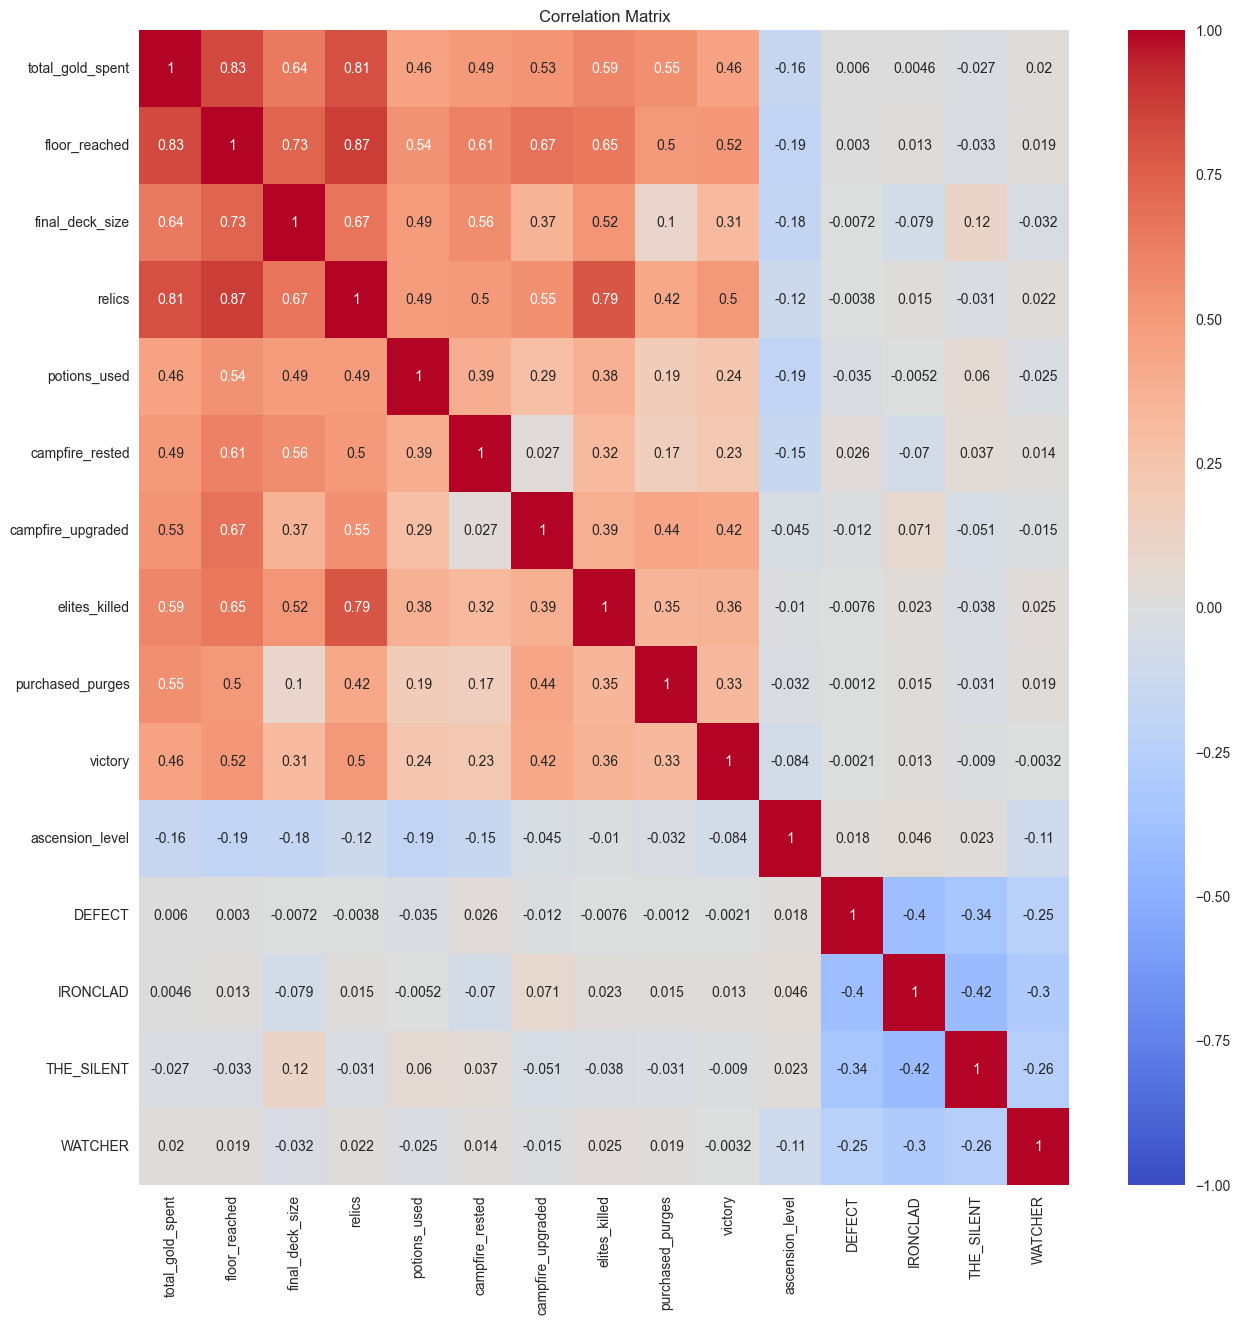

In [130]:
corr = df_final.corr()
fig, ax = plt.subplots(figsize=((len(df_final.columns)),(len(df_final.columns))))
ax.set_title("Correlation Matrix")
sn.heatmap(corr, annot=True, ax=ax, cmap="coolwarm", vmin=-1, vmax=1);

The above correlation matrix shows how closely related the features are to each other. The dataset shows no multicollinearity, which is when one feature perfectly maps to another feature. In that scenario, any other feature would lose their importance as they are no longer needed to make a prediction.

In this data, the "floor_reached" feature naturally scales with the "victory" feature. It's required to reach a certain floor to be able to win the game. If that floor had no bossfight and would directly cause a victory, then there would be multicollinearity in this dataset. In that case, predicting victory would be entirely possible by looking at that single feature.

In [131]:
df_X = df_final.loc[:, df_final.columns != "victory"]
df_y = df_final.loc[:, df_final.columns == "victory"]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42, stratify=df_y["victory"])

Dividing the dataset's target feature & independent features, and splitting the dataset into testing and training sets. The choice has been made for a 70:30 test design split, which is one of the common ratios to use.

It's worth noting that there is a class imbalance present in the target feature. This is naturally the case as many more runs end up in losses than victories, even more so as the <span style="color:#D0221a;">Ascension</span> level rises.

In [132]:
len(X_train), len(y_train), len(X_test), len(y_test)

(1243938, 1243938, 533117, 533117)

3 diffent classification models will be tested and evaluated to see if the project's premise is possible and realistic. These models are:

- K Nearest Neighbours
- Naive Bayes
- Random Forest

In [133]:
def plot_roc_auc(model, test_X, test_y):
    y_proba = model.predict_proba(test_X)
    fpr, tpr, treshhold = roc_curve(test_y, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.title(f"{type(model).__name__} ROC AUC Curve")
    plt.plot(fpr, tpr, "b", label = "AUC = %0.2f" % roc_auc)
    plt.legend(loc = "lower right")
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()

In addition, the above helper function is defined to plot ROC (Receiver Operating Characteristics) AUC (Area Under the Curve) curves to avoid unnecessary code repetition. The ROC AUC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

In [134]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model = knn_model.fit(X_train, y_train["victory"])
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.97      0.97    489233
        True       0.66      0.73      0.69     43884

    accuracy                           0.95    533117
   macro avg       0.82      0.85      0.83    533117
weighted avg       0.95      0.95      0.95    533117



In [135]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train["victory"])
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.92      0.96    489233
        True       0.52      0.99      0.68     43884

    accuracy                           0.92    533117
   macro avg       0.76      0.95      0.82    533117
weighted avg       0.96      0.92      0.93    533117



In [136]:
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train["victory"])
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    489233
        True       1.00      0.99      0.99     43884

    accuracy                           1.00    533117
   macro avg       1.00      0.99      1.00    533117
weighted avg       1.00      1.00      1.00    533117



The results show that classification with this data is possible but the results aren't very amazing quite yet. The K Nearest Neighbours and Naive Bayes models are able to predict losses rather well, with accuracies reaching percentages into the upper 90s. However, the ability to correctly predict victories is lacking behind. 

The Random Forest model seems to perform near-perfectly. This seems a bit suspect as the other models are lacking in quality.

Overall, the results here are a clear case of overfitting. As stated earlier, there is an inherent class imbalance present in the target variable due to most runs ending in defeat. There are multiple ways to resolve this issue, with one being undersampling.

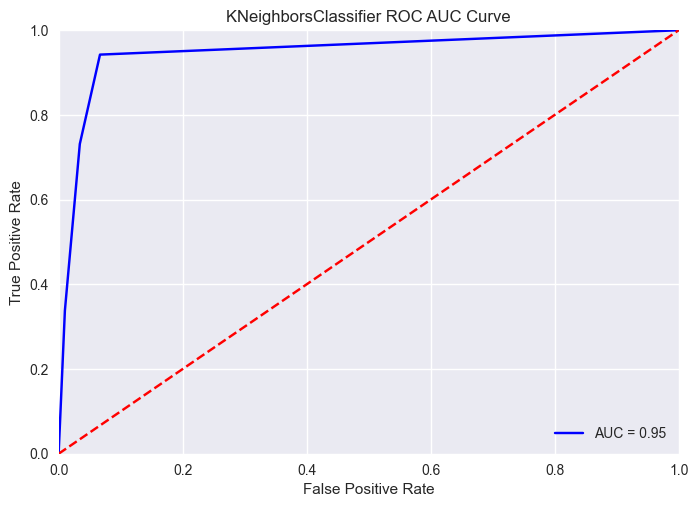

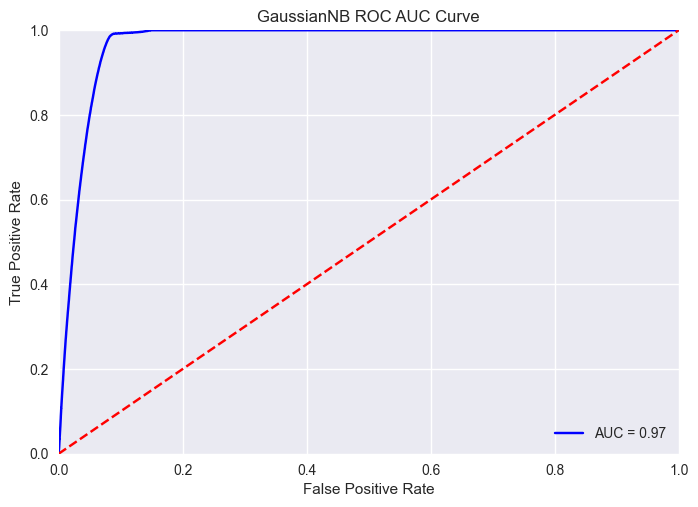

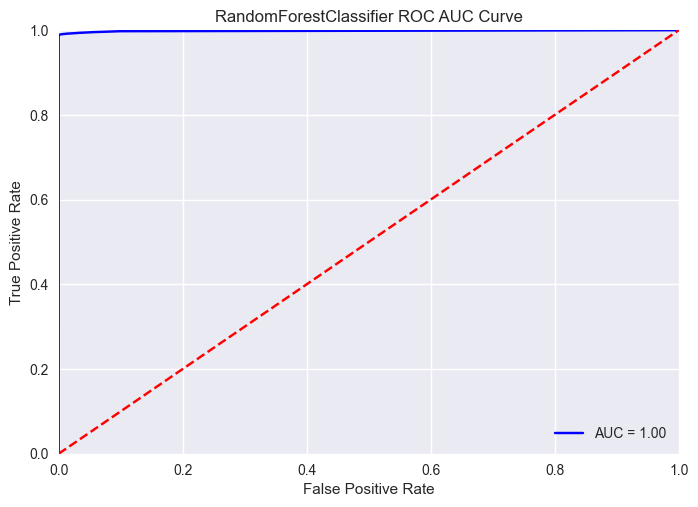

In [139]:
plot_roc_auc(knn_model, X_test, y_test)
plot_roc_auc(nb_model, X_test, y_test)
plot_roc_auc(rf_model, X_test, y_test)

### Undersampling

Undersampling is the practice of removing data with the goal of making the frequency of classes in the target variable even. Oversampling would be the opposite, which is creating new data for underrepresented classes instead. The choice for undersampling was made to reduce the enormous dataset size a bit, and to see if good results can be produced with a smaller amount of data.

In [13]:
all_losses = df_final.loc[df_final["victory"] == False]
all_wins = df_final.loc[df_final["victory"] == True]

In [14]:
loss_count, win_count = df_final["victory"].value_counts()
loss_count, win_count

(1630776, 146279)

Counting how often defeats and victories occur, respectively.

In [15]:
all_losses_under = all_losses.sample(win_count, random_state=42)
len(all_losses_under)

146279

Creating a new dataset, containing a number of rows with losses equal to the size of the dataset with all victories.

In [16]:
df_final_under = pd.concat([all_losses_under, all_wins])
df_final_under.reset_index(inplace=True, drop=True)
df_final_under.shape

(292558, 15)

In [17]:
df_final_under["victory"].value_counts()

False    146279
True     146279
Name: victory, dtype: int64

After stitching both datasets together, it can be observed that defeats and victories are now equally available. The new dataset now contains 292,558 rows in total. This is a major decrease compared to the 1,777,055 rows before, but it is still a hefty amount of data to work with.

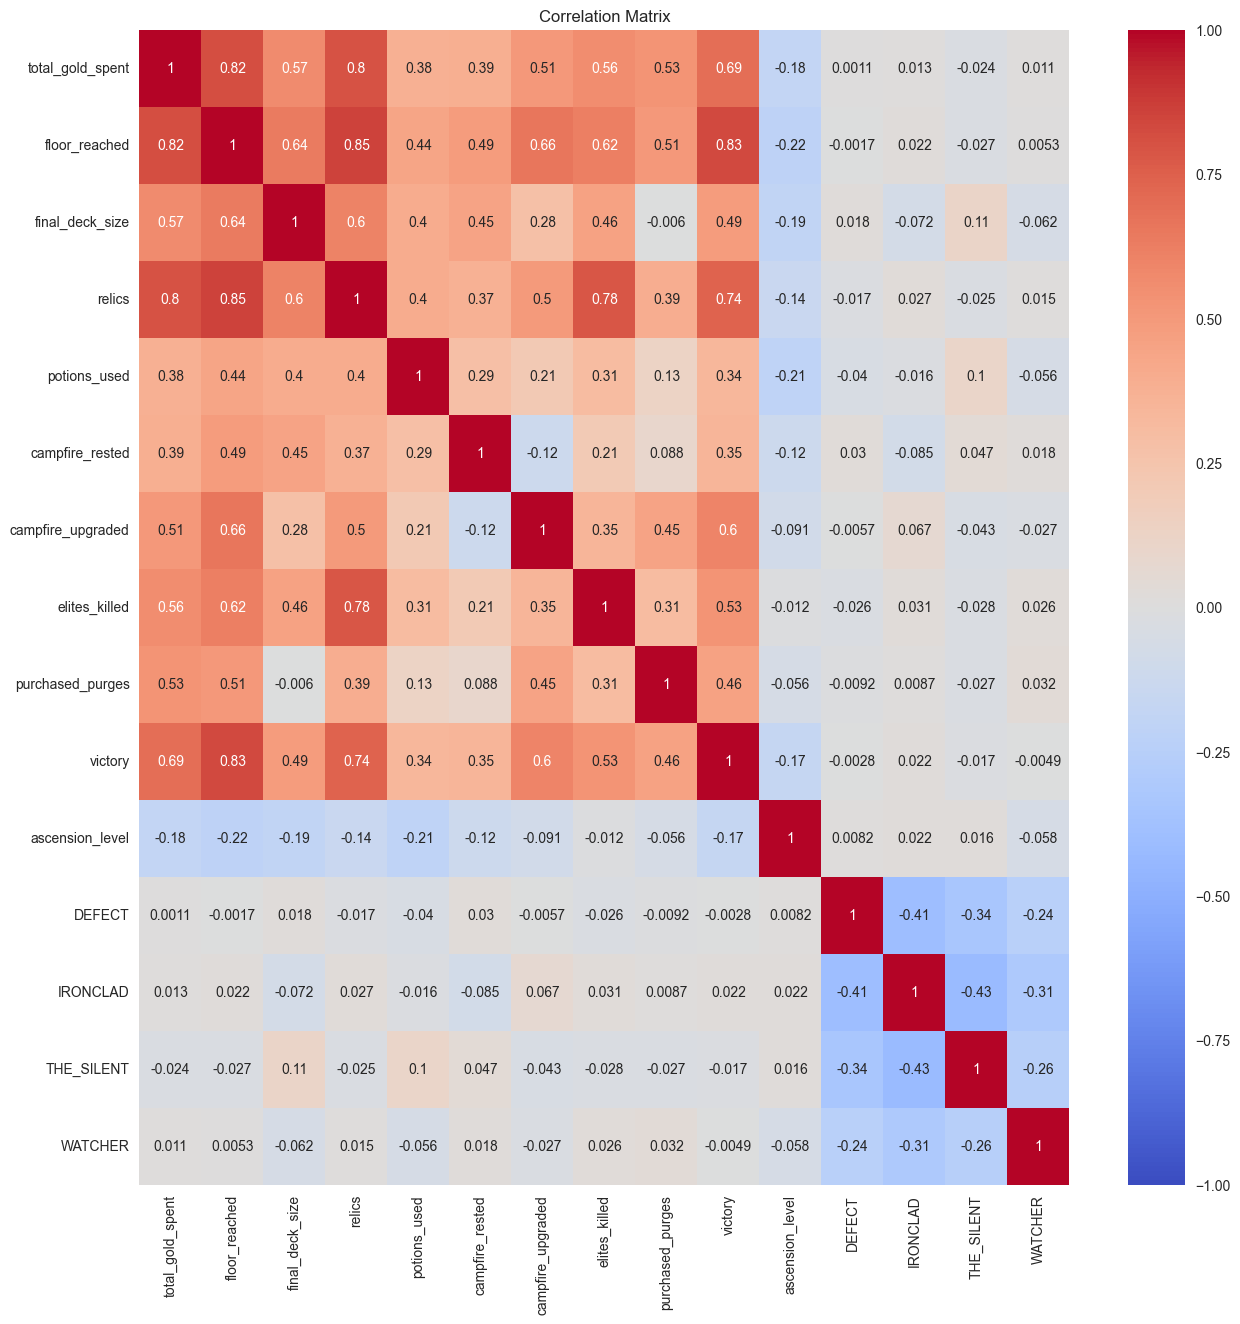

In [18]:
corr = df_final_under.corr()
fig, ax = plt.subplots(figsize=((len(df_final_under.columns)),(len(df_final_under.columns))))
ax.set_title("Correlation Matrix")
sn.heatmap(corr, annot=True, ax=ax, cmap="coolwarm", vmin=-1, vmax=1);

The correlation matrix has stayed relatively the same with still no multicollinearity being present.

In [19]:
df_X = df_final_under.loc[:, df_final_under.columns != "victory"]
df_y = df_final_under.loc[:, df_final_under.columns == "victory"]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42, stratify=df_y["victory"])

In [20]:
len(X_train), len(y_train), len(X_test), len(y_test)

(204790, 204790, 87768, 87768)

The dataset is once again divided according to the principes previously used. The stratify option guarantees that each part of the data will contain a proportional number of defeats and victories as well. The K Nearest Neighbours, Naive Bayes, and Random Forest models can now be used again to observe differences in results.

In [21]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model = knn_model.fit(X_train, y_train["victory"])
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.91      0.95     43884
        True       0.92      0.98      0.95     43884

    accuracy                           0.95     87768
   macro avg       0.95      0.95      0.95     87768
weighted avg       0.95      0.95      0.95     87768



In [22]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train["victory"])
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.91      0.95     43884
        True       0.92      0.99      0.95     43884

    accuracy                           0.95     87768
   macro avg       0.96      0.95      0.95     87768
weighted avg       0.96      0.95      0.95     87768



In [23]:
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train["victory"])
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99     43884
        True       1.00      0.99      0.99     43884

    accuracy                           0.99     87768
   macro avg       0.99      0.99      0.99     87768
weighted avg       0.99      0.99      0.99     87768



The results for the models show a vast increase in accuracy for the prediction of runs that end in victory. This means that the issue of overfitting has been solved and that the models are now capable of properly identifying victorious runs.

It's also possible to check which features are the most important. This could already be observed in the correlation matrix, but a model's feature importance can be checked to compare hypothesis and results. Not every model has this capability, such as K Nearest neighbours. However, it is possible for the Random Forest model.

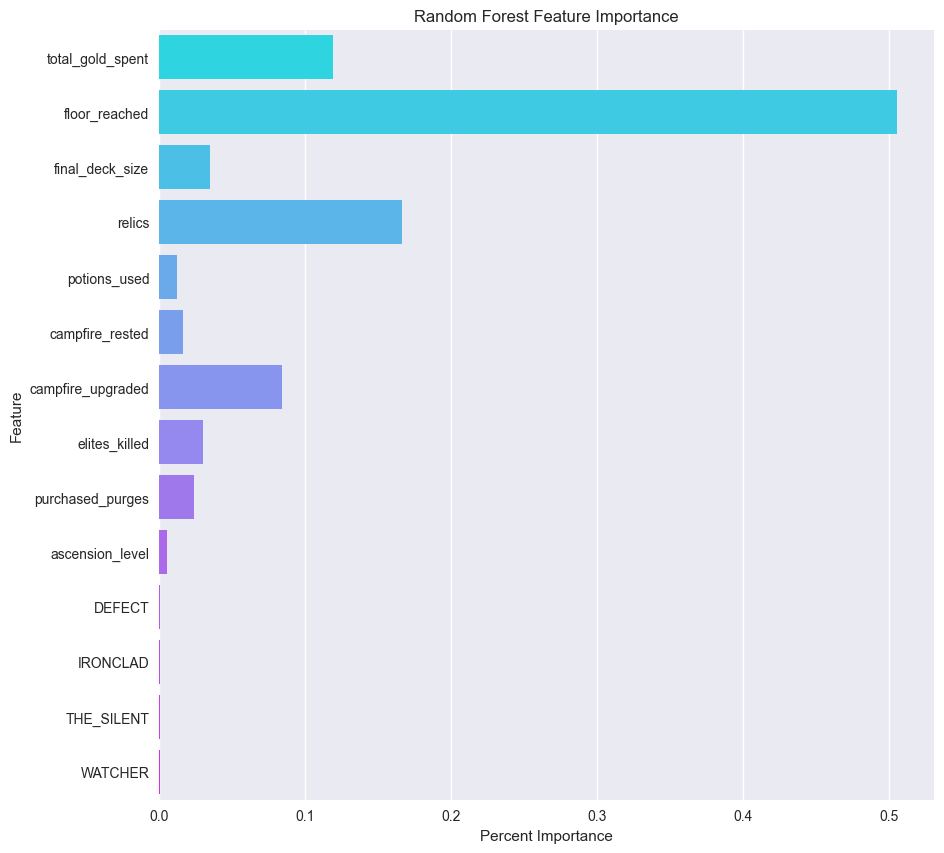

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
sn.barplot(x=rf_model.feature_importances_, y=df_X.columns, palette='cool', ax=ax, orient='h')
ax.set_xticks(np.linspace(0,0.5,6))
ax.set_title('Random Forest Feature Importance')
ax.set_xlabel('Percent Importance')
ax.set_ylabel('Feature');

As visible, the "floor_reached" feature contributes the most to being able to predict whether a run ends in defeat or victory. This is expected as it's impossible for a run to be won without reaching floor 51, which is where the Act 3 boss fight takes place. Reaching this floor does not guarantee a win either, which grants importance to the other features in being able to determine whether a player was strong enough to defeat the boss.

This begs the question: what happens if the "floor_reached" feature is omitted?

In [25]:
df_X = df_X.loc[:, df_X.columns != "floor_reached"]
df_y = df_y.loc[:, df_y.columns != "floor_reached"]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42, stratify=df_y["victory"])

In [26]:
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train["victory"])
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.88      0.93     43884
        True       0.89      0.98      0.93     43884

    accuracy                           0.93     87768
   macro avg       0.93      0.93      0.93     87768
weighted avg       0.93      0.93      0.93     87768



Even without the "floor_reached" feature, the Random Forest model is still capable of distinguishing victories and defeats, albeit not perfectly. This shows that the other features are capable of holding their own merit.

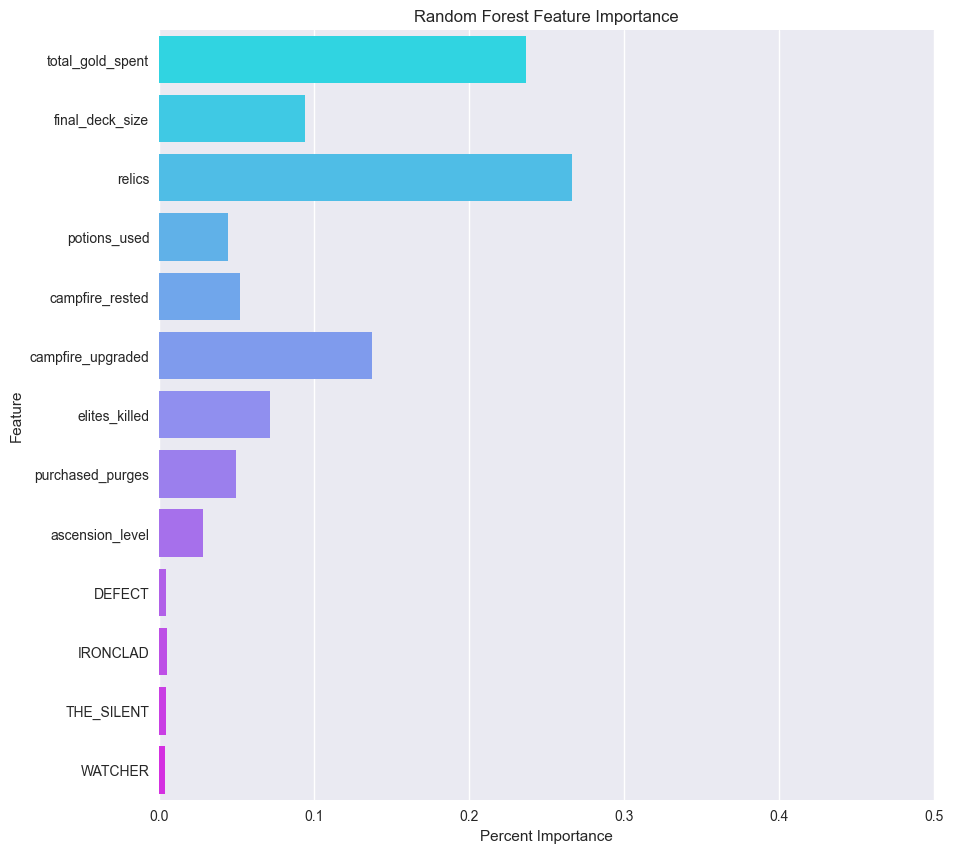

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
sn.barplot(x=rf_model.feature_importances_, y=df_X.columns, palette='cool', ax=ax, orient='h')
ax.set_xticks(np.linspace(0,0.5,6))
ax.set_title('Random Forest Feature Importance')
ax.set_xlabel('Percent Importance')
ax.set_ylabel('Feature');

With the "floor_reached" feature gone, the "relics" features takes over as the most important feature. In addition, all the other features see an increase in importance as well, some smaller or larger.

All of these feature's contents tend to scale as a run takes longer to finish. What these results mean, in theory, is that the acquisition of relics contributes the most to player power. During the game, the player is limited in their actions by a set number of energy every turn, but relics are capable of increasing this energy cap. More energy equals the ability to play more cards, which translates to more damage, more defense, faster enemy kills, etc.

# The Heart <a name="heart" />

A run in Slay the Spire does not have to end in Act 3 at floor 51. There is a secret Act 4 available, with its boss on floor 55 (Corrupt Heart) acting as the true final enemy of the game. It's only possible to enter this act by playing on any <span style="color:#D0221a;">Ascension</span> difficulty and collecting 3 keys from various sources.

It's possible to take a closer look at this final act of the game by setting a minimum floor reached requirement.

In [28]:
df_heart = df_final.loc[df_final["floor_reached"] >= 52]

In [29]:
df_X = df_heart.loc[:, df_heart.columns != "victory"]
df_y = df_heart.loc[:, df_heart.columns == "victory"]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42, stratify=df_y["victory"])

In [92]:
len(X_train), len(y_train), len(X_test), len(y_test)

(33081, 33081, 14178, 14178)

As this final act is harder to reach and requires the player to undergo various trials on at least an <span style="color:#D0221a;">Ascension</span> difficulty, there are naturally much fewer runs available.

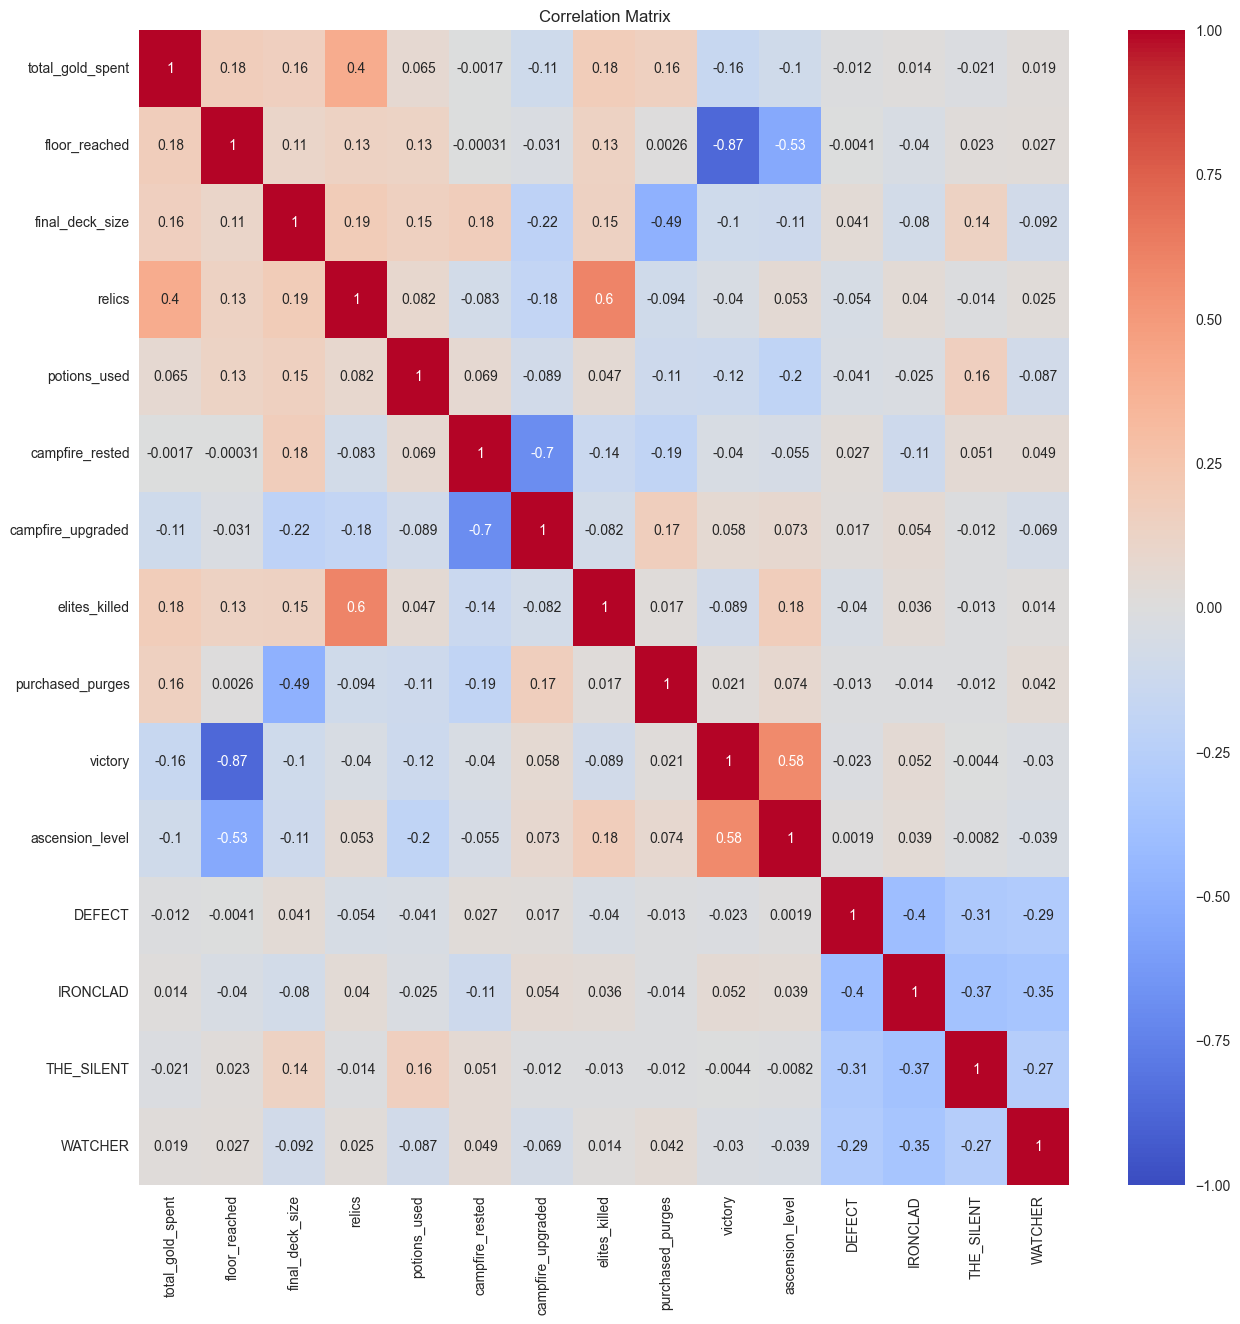

In [34]:
corr = df_heart.corr()
fig, ax = plt.subplots(figsize=((len(df_heart.columns)),(len(df_heart.columns))))
ax.set_title("Correlation Matrix")
sn.heatmap(corr, annot=True, ax=ax, cmap="coolwarm", vmin=-1, vmax=1);

When zooming in on this specific part of the game, the correlation matrix shows vastly different results. The features contributing the most to predictions will be "floor_reached" and "ascension_level".

In [35]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model = knn_model.fit(X_train, y_train["victory"])
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.99      0.98     13394
        True       0.77      0.67      0.72       784

    accuracy                           0.97     14178
   macro avg       0.87      0.83      0.85     14178
weighted avg       0.97      0.97      0.97     14178



In [36]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train["victory"])
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     13394
        True       0.98      0.97      0.97       784

    accuracy                           1.00     14178
   macro avg       0.99      0.98      0.99     14178
weighted avg       1.00      1.00      1.00     14178



In [37]:
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train["victory"])
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     13394
        True       0.99      0.97      0.98       784

    accuracy                           1.00     14178
   macro avg       0.99      0.98      0.99     14178
weighted avg       1.00      1.00      1.00     14178



The models still show the ability to correctly differentiate victories and defeats in Act 4 of the game, with K Nearest Neighbours suffering again with predicting victories. It's important to note that in this version of the data, the class imbalance has not been addressed yet.

### Undersampling

In [38]:
all_losses = df_heart.loc[df_heart["victory"] == False]
all_wins = df_heart.loc[df_heart["victory"] == True]

In [39]:
loss_count, win_count = df_heart["victory"].value_counts()
loss_count, win_count

(44646, 2613)

In total, there are only 2613 Act 4 victories available in the dataset, showing how difficult it is to beat this part of the game on average. Undersampling will thus drastically decrease the dataset size.

In [40]:
all_losses_under = all_losses.sample(win_count, random_state=42)
len(all_losses_under)

2613

In [44]:
df_heart_under = pd.concat([all_losses_under, all_wins])
df_heart_under.reset_index(inplace=True, drop=True)
df_heart_under.shape

(5226, 15)

In [45]:
df_heart_under["victory"].value_counts()

False    2613
True     2613
Name: victory, dtype: int64

In [47]:
df_X = df_heart_under.loc[:, df_heart_under.columns != "victory"]
df_y = df_heart_under.loc[:, df_heart_under.columns == "victory"]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42, stratify=df_y["victory"])

In [48]:
len(X_train), len(y_train), len(X_test), len(y_test)

(3658, 3658, 1568, 1568)

In [49]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model = knn_model.fit(X_train, y_train["victory"])
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.89      0.92       784
        True       0.89      0.97      0.93       784

    accuracy                           0.93      1568
   macro avg       0.93      0.93      0.93      1568
weighted avg       0.93      0.93      0.93      1568



In [50]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train["victory"])
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       784
        True       1.00      0.98      0.99       784

    accuracy                           0.99      1568
   macro avg       0.99      0.99      0.99      1568
weighted avg       0.99      0.99      0.99      1568



In [51]:
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train["victory"])
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       784
        True       1.00      0.98      0.99       784

    accuracy                           0.99      1568
   macro avg       0.99      0.99      0.99      1568
weighted avg       0.99      0.99      0.99      1568



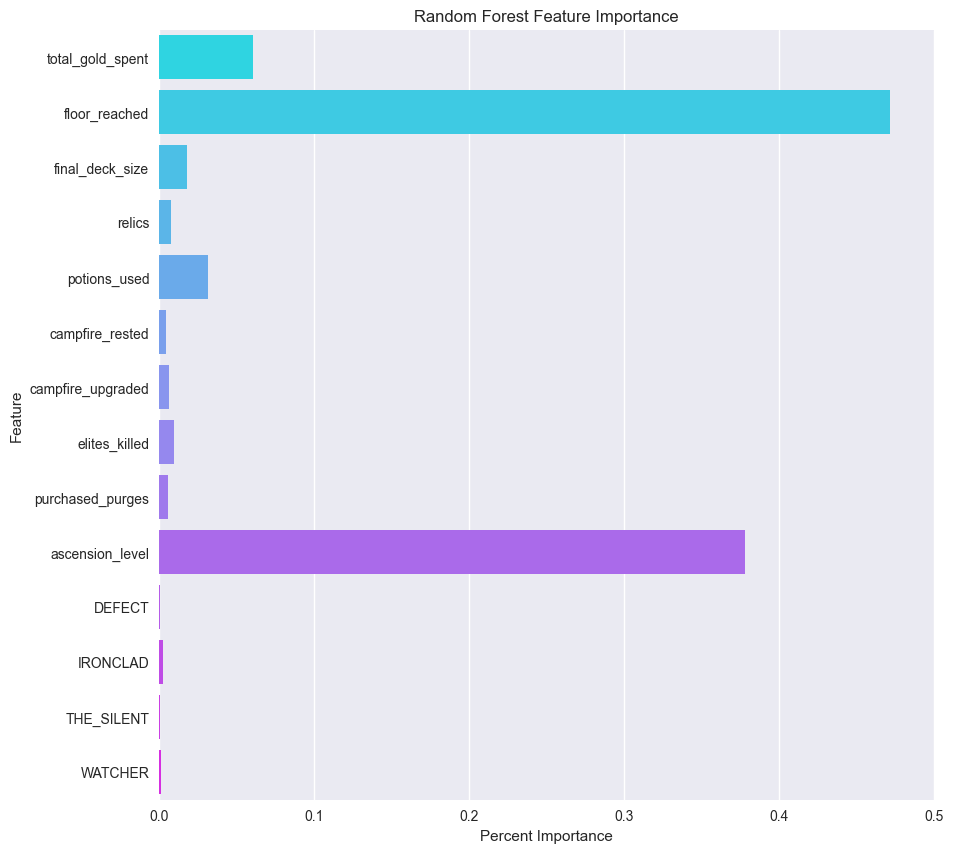

In [52]:
fig, ax = plt.subplots(figsize=(10,10))
sn.barplot(x=rf_model.feature_importances_, y=df_X.columns, palette='cool', ax=ax, orient='h')
ax.set_xticks(np.linspace(0,0.5,6))
ax.set_title('Random Forest Feature Importance')
ax.set_xlabel('Percent Importance')
ax.set_ylabel('Feature');

Solving the issue of overfitting through undersampling once again improves the overall model results. As expected, the "floor_reached" and "ascension_level" features contribute the most to the model results. As previously stated, it's necessary to reach a certain floor to have a chance at victory. Stretched out over 51 floors, the contribution of each individual floor to victory or defeat is very minor, with elites and bosses having more impact.

Act 4 is a bit different as it is only 4 floor long. In addition, there are no randomly generated paths. The floor has a campfire, a shop, a unique elite fight, and finally the Corrupt Heart boss. This means that it's only possible to lose on floors the floors 54 and 55. Due to being more compact and static of an act, these floors make the feature carry much more weight. The "ascension_level" feature also makes an understandable contribution. This is the most difficult part of the game and <span style="color:#D0221a;">Ascension</span> increases the difficulty even further.

Both features can be omitted to see the impact it will have on model predictions.

In [56]:
df_X = df_X.loc[:, df_X.columns != "floor_reached"]
df_y = df_y.loc[:, df_y.columns != "floor_reached"]
df_X = df_X.loc[:, df_X.columns != "ascension_level"]
df_y = df_y.loc[:, df_y.columns != "ascension_level"]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42, stratify=df_y["victory"])

In [59]:
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train["victory"])
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.72      0.73      0.72       784
        True       0.73      0.72      0.72       784

    accuracy                           0.72      1568
   macro avg       0.72      0.72      0.72      1568
weighted avg       0.72      0.72      0.72      1568



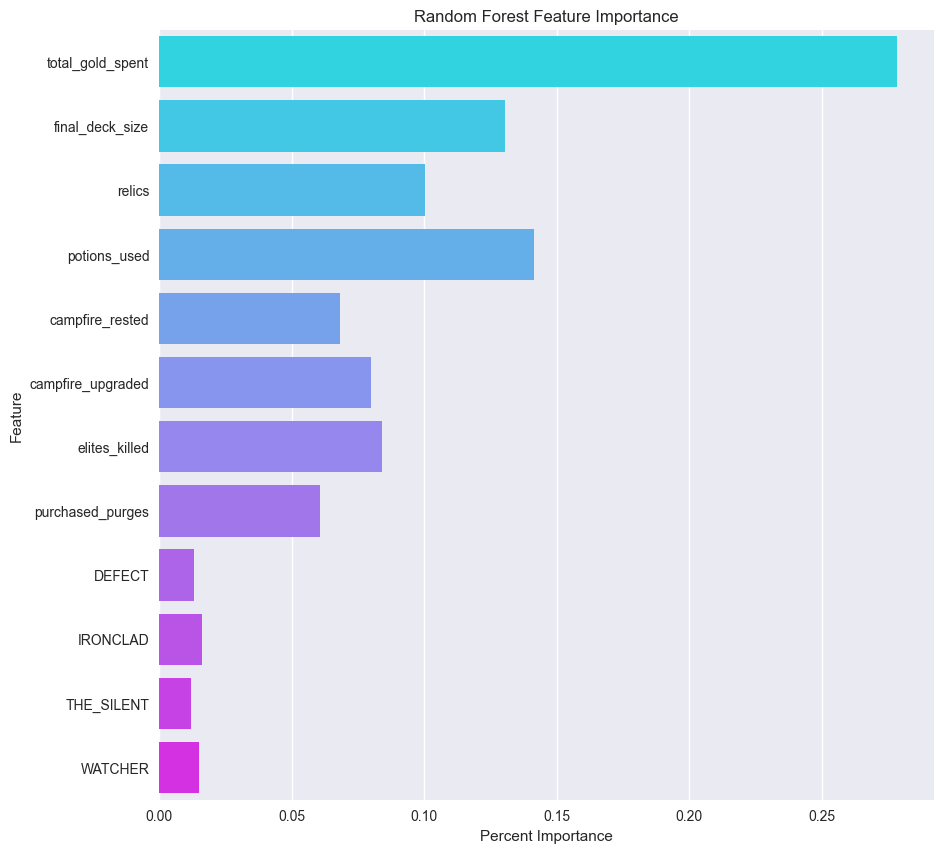

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
sn.barplot(x=rf_model.feature_importances_, y=df_X.columns, palette='cool', ax=ax, orient='h')
ax.set_title('Random Forest Feature Importance')
ax.set_xlabel('Percent Importance')
ax.set_ylabel('Feature');

With the aforementioned 2 features omitted, model performance suffers, but the importance of the remaining features becomes more clear. Gold becomes the next most important feature. Due to shops, it translates to additional cards, relics, card purges, potions, and upgraded cards. At the end of Act 3, the player usually has leftover gold which goes unspent. However, that gold, in addition to gold from the Act 3 boss, can be spent on the last shop in Act 4. This provides a small additional increase in player power that does not exist in runs that do not aim to beat the Corrupt Heart.

In [143]:
df_final.loc[(df_final["floor_reached"] == 55) & (df_final["ascension_level"] == 20), "victory"].value_counts()

False    782
True       5
Name: victory, dtype: int64

It's not possible to zoom in further on <span style="color:#D0221a;">Ascension 20</span> Act 4 victories. Out of the 1,777,055 total runs, only 787 attempts were made at an <span style="color:#D0221a;">Ascension 20</span> Corrupt Heart kill. And out of those 787 attempts, only 5 players succeeded. Thus, there is not enough data available for the models to work with. However, this makes it all the more clear how difficult it is to achieve this feat.

# Conclusion <a name="conclusion" />